<a href="https://www.kaggle.com/code/jassermoreno/analisis-pruebas-nacionales-rd?scriptVersionId=119479239" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **Análisis de Calificaciones a Nivel Nacional**


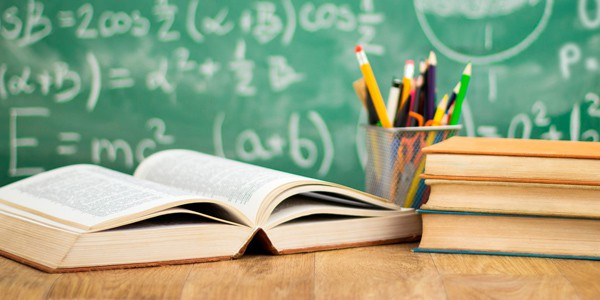

El rendimiento académico es un indicador clave del progreso de una nación en su camino hacia el desarrollo. En un esfuerzo por medir y mejorar la calidad de la educación, los gobiernos suelen llevar a cabo exámenes estandarizados para evaluar el desempeño de los estudiantes. En este análisis, se han utilizado los datos de calificaciones nacionales para explorar el rendimiento académico de los estudiantes en el país. El objetivo de este análisis es proporcionar información detallada sobre las calificaciones promedio de los estudiantes, el número de estudiantes que aprueban o suspenden, y el desempeño de las diferentes regiones y provincias. Además, se pretende analizar la relación entre el desempeño académico y otros factores, como el género, la modalidad y el tipo de institución. Este análisis no solo puede ser útil para comprender mejor la educación en nuestro país, sino que también puede proporcionar información valiosa para los responsables de la toma de decisiones en la mejora de la educación.

In [1]:
!pip install sweetviz
!pip install pandasprofiling
!pip install ipywidgets

import pandas as pd
import folium
import branca
from folium.plugins import MarkerCluster
from folium.plugins import HeatMap
from folium import Marker

import fiona
import geopandas as gpd
import shapefile
import openpyxl
import numpy as np
import webbrowser
import pandas_profiling as pp
import sweetviz as sv
import pandas_profiling as pp
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import math

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

from IPython.display import HTML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 32.1 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement pandasprofiling (from versions: none)
ERROR: No matching distribution found for pandasprofiling


/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


#  Dataset

In [2]:
provincias_shp = gpd.\
read_file('/kaggle/input/shape-files-rd/SHP_RD_2010/PROVCenso2010.shp')
sectores = gpd.read_file('/kaggle/input/shape-files-rd/SHP_RD_2010/SECCenso2010.shp')
barrios = gpd.read_file('/kaggle/input/shape-files-rd/SHP_RD_2010/BPCenso2010.shp')
provincias_rd = pd.read_excel('/kaggle/input/dominican-republic-provincias-coord/tbl_GEO_Provincias.xlsx')
municipios = gpd.read_file('/kaggle/input/shape-files-rd/SHP_RD_2010/MUNCenso2010.shp')
escuelas = pd.read_excel('/kaggle/input/centros-educativos-rd/Tdb-centros-educativos-de-republica-dominicana-2021.xlsx')

df = pd.read_excel('/kaggle/input/estadisticas-pruebasnacionales-rd-1620/s0d-estadisticas-de-pruebas-nacionales-2016-2020-xlsxlsx.xlsx')


df['Español'] = df['Español'].fillna(0)
df['Matemáticas'] = df['Matemáticas'].fillna(0)
df['Sociales'] = df['Sociales'].fillna(0)
df['Naturales'] = df['Naturales'].fillna(0)
df['Cantidad Promovidos'] = df['Cantidad Promovidos'].fillna(0)
df['Cantidad Aplazados'] = df['Cantidad Aplazados'].fillna(0)

escuelas['Código_de_Centro'] = escuelas['Planta Física'].str[:8]
escuelas['Código_de_Centro'] = pd.to_numeric(escuelas['Código_de_Centro'], errors='coerce')
escuelas['Código_de_Centro'] = escuelas['Código_de_Centro'].astype(int)

df['Código de Centro'] = pd.to_numeric(df['Código de Centro'], errors='coerce')
df['Código de Centro'] = df['Código de Centro'].astype(int)

In [3]:
df_1 = pd.merge(df,escuelas[['Código_de_Centro','Cordenadas Latitud','Cordenadas Longitud','Provincia']],how='left',left_on='Código de Centro',
                        right_on='Código_de_Centro')

df = df_1

# Analisis Descriptivo

In [4]:
# Calculamos el promedio de calificaciones por estudiante
df['average_grade'] = df[['Español', 'Matemáticas', 'Sociales', 'Naturales']].mean(axis=1)



# Calculamos el índice de calificaciones por estudiante en cada estado
state_index = df.groupby(['Nombre de Centro'])['average_grade'].mean()
state_index

Nombre de Centro
37653                                   18.552500
 EL HATICO                               0.000000
 EUGENIO MARIA DE HOSTOS                 0.000000
 FELIX MARIA DEL MONTE                   0.000000
 FRANCISCO ANTONIO BATISTA GARCIA        0.000000
                                          ...    
ZENEIDA DE BLANCO, PROF - LAS AROMAS    16.685000
ZENON SANTANA                           17.152500
ZOILA MARIA ALMONTE                     13.142666
ZOILO CONTRERAS                         15.172934
ZURZA, LA                               19.096364
Name: average_grade, Length: 5248, dtype: float64

In [5]:

promovidos_por_periodo = df.groupby('Período')['Cantidad Promovidos', 'Cantidad Aplazados'].sum()
promovidos_por_periodo['Promedio de Aprobados'] = promovidos_por_periodo['Cantidad Promovidos'] / (promovidos_por_periodo['Cantidad Promovidos'] + promovidos_por_periodo['Cantidad Aplazados'])
promovidos_por_periodo['Promedio de Aplazados'] = promovidos_por_periodo['Cantidad Aplazados'] / (promovidos_por_periodo['Cantidad Promovidos'] + promovidos_por_periodo['Cantidad Aplazados'])

ax = promovidos_por_periodo[['Promedio de Aprobados', 'Promedio de Aplazados']].plot(kind='bar', figsize=(10,6), color=['#1f77b4', '#ff7f0e'], width=0.8)

mean_line = promovidos_por_periodo[['Promedio de Aprobados', 'Promedio de Aplazados']].mean()
ax.axhline(mean_line[0], color='#1f77b4', linestyle='--', label='Promedio de Aprobados')
ax.axhline(mean_line[1], color='#ff7f0e', linestyle='--', label='Promedio de Aplazados')
plt.legend()

plt.title('Promedio de estudiantes aprobados y aplazados por período')
plt.xlabel('Período')
plt.ylabel('Cantidad de estudiantes')
plt.show()

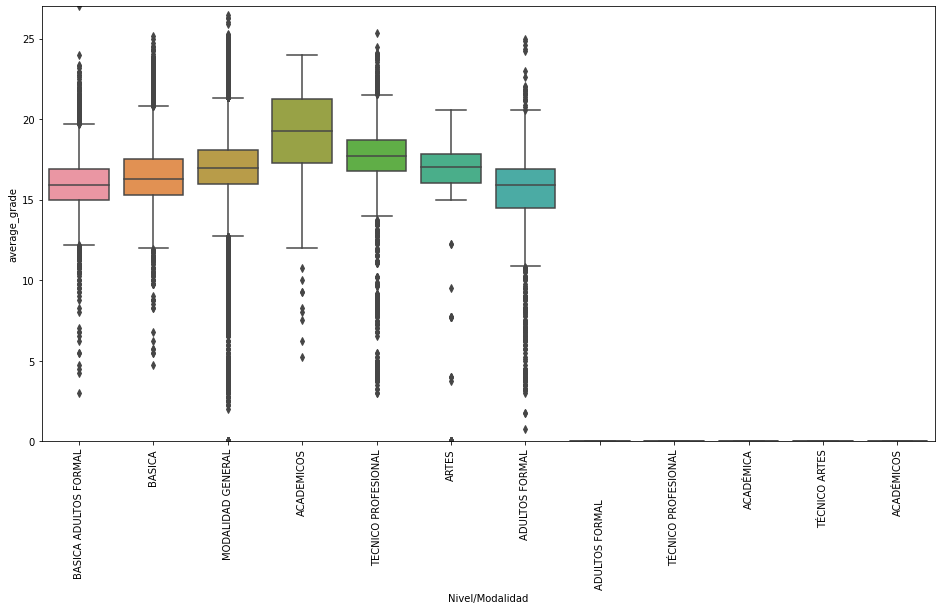

In [6]:
%matplotlib inline

var = 'Nivel/Modalidad'
max_s = df['average_grade'].max()
data = pd.concat([df['average_grade'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(16, 8))
fig = sns.boxplot(x=var, y="average_grade", data=df)
fig.axis(ymin=0, ymax=max_s);
plt.xticks(rotation=90);

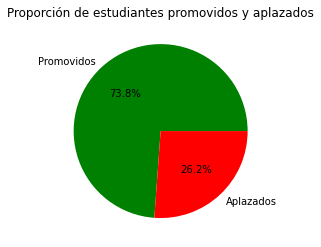

In [7]:
promovidos = df['Cantidad Promovidos'].sum()
aplazados = df['Cantidad Aplazados'].sum()
valores = [promovidos, aplazados]

etiquetas = ['Promovidos', 'Aplazados']
colores = ['green', 'red']

plt.pie(valores, labels=etiquetas, colors=colores, autopct='%1.1f%%')
plt.title('Proporción de estudiantes promovidos y aplazados')
plt.show()

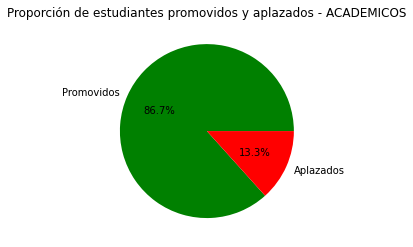

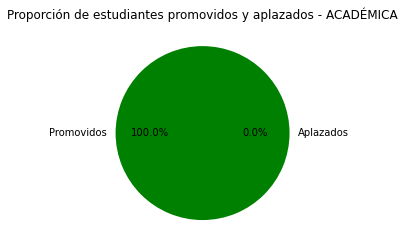

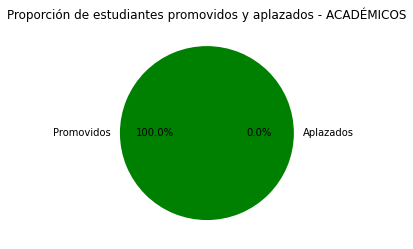

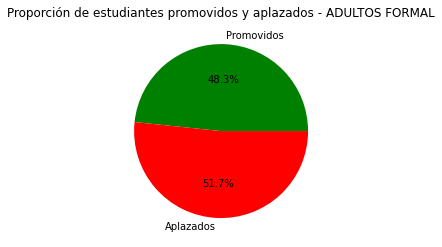

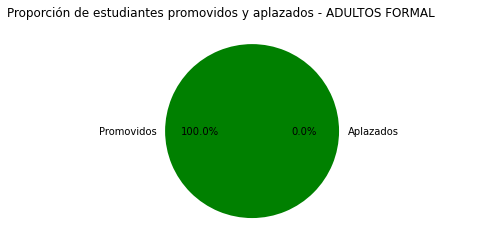

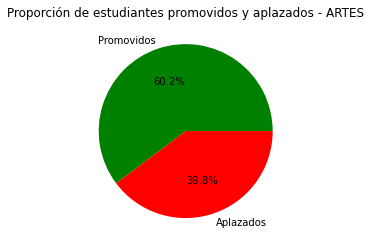

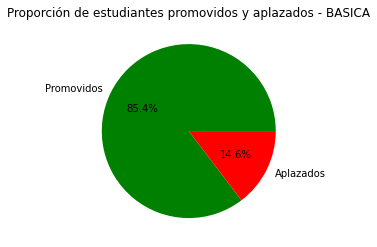

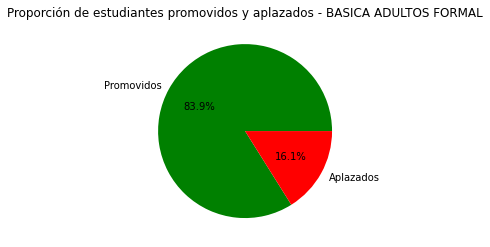

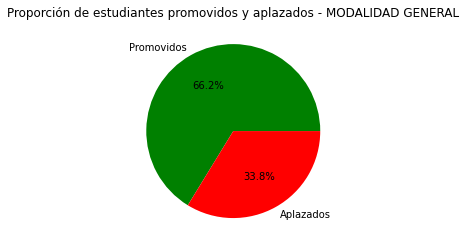

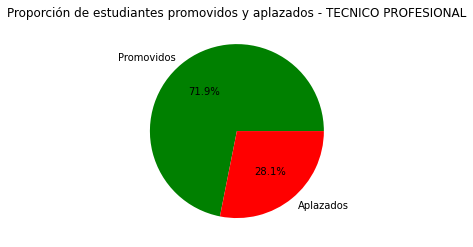

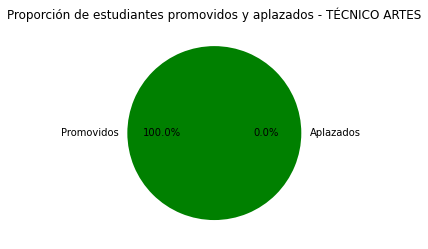

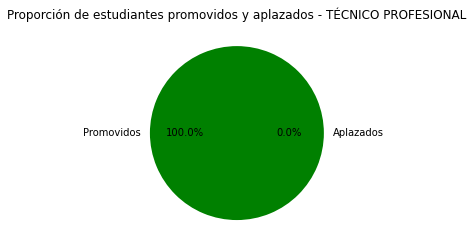

In [8]:
grupos = df.groupby('Nivel/Modalidad')

for nombre, grupo in grupos:
    promovidos = grupo['Cantidad Promovidos'].sum()
    aplazados = grupo['Cantidad Aplazados'].sum()
    valores = [promovidos, aplazados]
    etiquetas = ['Promovidos', 'Aplazados']
    colores = ['green', 'red']
    plt.pie(valores, labels=etiquetas, colors=colores, autopct='%1.1f%%')
    plt.title(f'Proporción de estudiantes promovidos y aplazados - {nombre}')
    plt.show()

In [9]:
# Agrupar los cargos por provincia y contar la cantidad de empleados en cada cargo
cargos_por_cluster = df.groupby(['Nombre de Centro','Matemáticas']).size().reset_index(name='cantidad')

# Obtener los cargos top 5 por cada provincia
top_cargos_por_cluster = cargos_por_cluster.groupby('Nombre de Centro').apply(lambda x: x.nlargest(5, 'cantidad'))

top_cargos_por_cluster

Nombre de Centro  \
Nombre de Centro                                                             
37653                             0                                  37653   
 EL HATICO                        1                              EL HATICO   
 EUGENIO MARIA DE HOSTOS          2             EUGENIO MARIA DE HOSTOS      
 FELIX MARIA DEL MONTE            3               FELIX MARIA DEL MONTE      
 FRANCISCO ANTONIO BATISTA GARCIA 4       FRANCISCO ANTONIO BATISTA GARCIA   
...                                                                    ...   
ZURZA, LA                         38140                          ZURZA, LA   
                                  38143                          ZURZA, LA   
                                  38135                          ZURZA, LA   
                                  38136                          ZURZA, LA   
                                  38137                          ZURZA, LA   

                                         Matemáticas  cantidad  
Nombre de Centro                                                
37653                             0            18.57         1  
 EL HATICO                        1             0.00         1  
 EUGENIO MARIA DE HOSTOS          2             0.00         1  
 FELIX MARIA DEL MONTE            3             0.00         1  
 FRANCISCO ANTONIO BATISTA GARCIA 4             0.00         1  
...                                              ...       ...  
ZURZA, LA                         38140        19.00         2  
                                  38143        20.50         2  
                                  38135        13.50         1  
                                  38136        16.50         1  
                                  38137        17.00         1  

[17505 rows x 3 columns]

# Análisis de rendimiento por materia y nivel/modalidad

In [10]:
rendimiento_matematicas = df.groupby(['Nivel/Modalidad'])['Matemáticas'].mean()
rendimiento_sociales = df.groupby(['Nivel/Modalidad'])['Sociales'].mean()
rendimiento_naturales = df.groupby(['Nivel/Modalidad'])['Naturales'].mean()
rendimiento_espanol = df.groupby(['Nivel/Modalidad'])['Español'].mean()

print(rendimiento_matematicas)
print('---------------------------------------------------------------------------------------')

print(rendimiento_sociales)
print('---------------------------------------------------------------------------------------')

print(rendimiento_naturales)
print('---------------------------------------------------------------------------------------')
print(rendimiento_espanol)

Nivel/Modalidad
ACADEMICOS                        17.094872
ACADÉMICA                          0.000000
ACADÉMICOS                         0.000000
ADULTOS FORMAL                    15.347541
ADULTOS FORMAL                     0.000000
ARTES                             14.751160
BASICA                            16.291616
BASICA ADULTOS FORMAL             15.958941
MODALIDAD GENERAL                 15.481167
TECNICO PROFESIONAL               17.039494
TÉCNICO ARTES                      0.000000
TÉCNICO PROFESIONAL                0.000000
Name: Matemáticas, dtype: float64
---------------------------------------------------------------------------------------
Nivel/Modalidad
ACADEMICOS                        18.622982
ACADÉMICA                          0.000000
ACADÉMICOS                         0.000000
ADULTOS FORMAL                    14.758775
ADULTOS FORMAL                     0.000000
ARTES                             15.086022
BASICA                            16.426041
BASICA ADU

# Identificación de centros con altos y bajos rendimientos aplicalo a python



In [11]:
# Ordenar los centros por porcentaje de estudiantes promovidos
centros_promovidos = df.sort_values(by='Cantidad Promovidos', ascending=False)

# Obtener los 10 centros con mayor porcentaje de estudiantes promovidos
mejores_centros = centros_promovidos.head(10)
print('Los 10 mejores centros en términos de porcentaje de estudiantes promovidos:')
print(mejores_centros[['Nombre de Centro', 'Cantidad Promovidos']])
print('---------------------------------------------------------------------------------------')

# Obtener los 10 centros con menor porcentaje de estudiantes promovidos
peores_centros = centros_promovidos.tail(10)
print('Los 10 peores centros en términos de porcentaje de estudiantes promovidos:')
print(peores_centros[['Nombre de Centro', 'Cantidad Promovidos']])

Los 10 mejores centros en términos de porcentaje de estudiantes promovidos:
                                      Nombre de Centro  Cantidad Promovidos
50910                                  LOS TRINITARIOS                  474
4460                   NUESTRA SEÑORA PERPETUO SOCORRO                  469
49847                               CENAPEC - SANTIAGO                  461
12229                               JOSE JOAQUIN PEREZ                  431
52004               CENAPEC - SANTO DOMINGO SURCENTRAL                  421
50919  POLITECNICO NUESTRA SEÑORA DEL PERPETUO SOCORRO                  400
50638                 CENAPEC - SANTO DOMINGO ORIENTAL                  400
50918  POLITECNICO NUESTRA SEÑORA DEL PERPETUO SOCORRO                  400
50917  POLITECNICO NUESTRA SEÑORA DEL PERPETUO SOCORRO                  400
50921  POLITECNICO NUESTRA SEÑORA DEL PERPETUO SOCORRO                  400
---------------------------------------------------------------------------------------


In [12]:
# Ordenar los centros por porcentaje de estudiantes aplazados
centros_aplazados = df.sort_values(by='Cantidad Aplazados', ascending=False)

# Obtener los 10 centros con mayor porcentaje de estudiantes aplazados
peores_centros = centros_aplazados.head(10)
print('Los 10 peores centros en términos de porcentaje de estudiantes aplazados:')
print(peores_centros[['Nombre de Centro', 'Cantidad Aplazados']])

print('---------------------------------------------------------------------------------------')

# Obtener los 10 centros con menor porcentaje de estudiantes aplazados
mejores_centros = centros_aplazados.tail(10)
print('Los 10 mejores centros en términos de porcentaje de estudiantes aplazados:')
print(mejores_centros[['Nombre de Centro', 'Cantidad Aplazados']])

Los 10 peores centros en términos de porcentaje de estudiantes aplazados:
                         Nombre de Centro  Cantidad Aplazados
21023                         CORBANO, EL               271.0
11947                          SARA ORTIZ               247.0
12192             GASTON FERNANDO DELIGNE               229.0
12000          FRANCISCO GREGORIO BILLINI               223.0
12002          FRANCISCO GREGORIO BILLINI               223.0
12001          FRANCISCO GREGORIO BILLINI               223.0
31990  CENAPEC - SANTO DOMINGO SURCENTRAL               213.0
21842                       ESPERANZA, LA               203.0
37562                     LOS TRINITARIOS               199.0
12006          FRANCISCO GREGORIO BILLINI               194.0
---------------------------------------------------------------------------------------
Los 10 mejores centros en términos de porcentaje de estudiantes aplazados:
                                   Nombre de Centro  Cantidad Aplazados
24879    

# Analisis de Genero

In [13]:

# Agrupar los datos por género y calcular el promedio de rendimiento en español y la cantidad de estudiantes en cada grupo
rendimiento_por_genero = df.groupby('Cantidad Femenino')['Español'].agg(['mean', 'count'])
rendimiento_por_genero = rendimiento_por_genero.rename(columns={'mean': 'Promedio de rendimiento', 'count': 'Cantidad de estudiantes'})
print(rendimiento_por_genero.head(10).sort_values(by='Cantidad de estudiantes', ascending=False ))

print('**************************************************************************************************')


# Promedio de rendimiento en matemáticas por género
rendimiento_matematicas_por_genero = df.groupby('Cantidad Femenino')['Matemáticas'].agg(['mean', 'count'])
rendimiento_matematicas_por_genero = rendimiento_matematicas_por_genero.rename(columns={'mean': 'Promedio de rendimiento', 'count': 'Cantidad de estudiantes'})
print(rendimiento_matematicas_por_genero.head(10).sort_values(by='Cantidad de estudiantes', ascending=False ))

print('**************************************************************************************************')

# Promedio de rendimiento en sociales por género
rendimiento_sociales_por_genero = df.groupby('Cantidad Femenino')['Sociales'].agg(['mean', 'count'])
rendimiento_sociales_por_genero = rendimiento_sociales_por_genero.rename(columns={'mean': 'Promedio de rendimiento', 'count': 'Cantidad de estudiantes'})
print(rendimiento_sociales_por_genero.head(10).sort_values(by='Cantidad de estudiantes', ascending=False ))

print('**************************************************************************************************')


# Promedio de rendimiento en naturales por género
rendimiento_naturales_por_genero = df.groupby('Cantidad Femenino')['Naturales'].agg(['mean', 'count'])
rendimiento_naturales_por_genero = rendimiento_naturales_por_genero.rename(columns={'mean': 'Promedio de rendimiento', 'count': 'Cantidad de estudiantes'})
print(rendimiento_naturales_por_genero.head(10).sort_values(by='Cantidad de estudiantes', ascending=False ))

                   Promedio de rendimiento  Cantidad de estudiantes
Cantidad Femenino                                                  
1                                13.742275                     6411
0                                14.262666                     4695
2                                14.437690                     3881
3                                14.911374                     3027
4                                15.536899                     2562
5                                15.796159                     2108
6                                15.781787                     1988
7                                16.159356                     1690
8                                15.961922                     1520
9                                15.924331                     1393
**************************************************************************************************
                   Promedio de rendimiento  Cantidad de estudiantes
Cantidad Femenino

# Analisis de Correlacion

In [14]:
import pandas as pd

# Selecciona sólo las variables numéricas
numeric_columns = ['Español', 'Matemáticas', 'Sociales', 'Naturales', 'Cantidad de estudiantes', 'Cantidad Femenino', 'Cantidad masculino', 'Cantidad Promovidos', 'Cantidad Aplazados']

# Calcula la matriz de correlación
correlation_matrix = df[numeric_columns].corr()

# Muestra la matriz de correlación
correlation_matrix

,Español,Matemáticas,Sociales,Naturales,Cantidad de estudiantes,Cantidad Femenino,Cantidad masculino,Cantidad Promovidos,Cantidad Aplazados
Español,1.000000,0.855201,0.875273,0.864956,0.004570,0.029678,-0.033857,-0.079920,0.207459
Matemáticas,0.855201,1.000000,0.855751,0.873609,-0.042452,-0.015937,-0.077597,-0.124408,0.173577
Sociales,0.875273,0.855751,1.000000,0.882746,0.004031,0.028881,-0.033174,-0.079738,0.206383
Naturales,0.864956,0.873609,0.882746,1.000000,-0.027109,-0.004078,-0.058838,-0.112143,0.190106
Cantidad de estudiantes,0.004570,-0.042452,0.004031,-0.027109,1.000000,0.960526,0.916961,0.947931,0.670497
Cantidad Femenino,0.029678,-0.015937,0.028881,-0.004078,0.960526,1.000000,0.782324,0.901666,0.685822
Cantidad masculino,-0.033857,-0.077597,-0.033174,-0.058838,0.916961,0.782324,1.000000,0.898356,0.561559
Cantidad Promovidos,-0.079920,-0.124408,-0.079738,-0.112143,0.947931,0.901666,0.898356,1.000000,0.412440
Cantidad Aplazados,0.207459,0.173577,0.206383,0.190106,0.670497,0.685822,0.561559,0.412440,1.000000


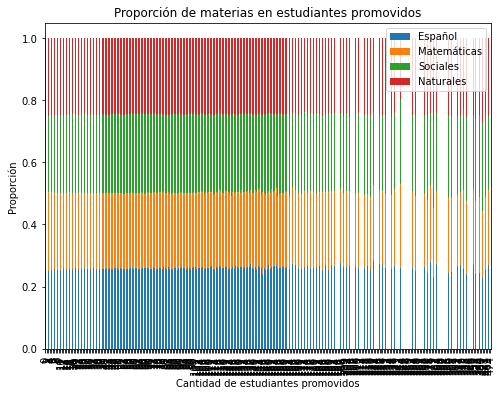

In [15]:
materias = ['Español', 'Matemáticas', 'Sociales', 'Naturales']
promovidos_por_materia = df.groupby('Cantidad Promovidos')[materias].sum()

total_promovidos = promovidos_por_materia.sum(axis=1)
proporcion_por_materia = promovidos_por_materia.divide(total_promovidos, axis=0)

proporcion_por_materia.plot(kind='bar', stacked=True, figsize=(8,6))
plt.title('Proporción de materias en estudiantes promovidos')
plt.xlabel('Cantidad de estudiantes promovidos')
plt.ylabel('Proporción')
plt.legend(loc='upper right')
plt.show()

# Analisis GeoEspacial

In [16]:

df_map = df.groupby(['Nombre de Centro','Regional','Cordenadas Latitud','Cordenadas Longitud'])\
['Sociales','Matemáticas','Español','Naturales'].mean()

df_map = df.dropna(subset=['Cordenadas Latitud', 'Cordenadas Longitud'])

# Crea un mapa centrado en una ubicación geográfica específica
mapa = folium.Map(location=[18.5109567,-69.8709901,], zoom_start=10)

# Agrega los marcadores correspondientes a cada centro educativo
for index, row in df_map.iterrows():
    popup_text = f"Nombre del Centrod_map: {row['Nombre de Centro']} <br> Regional: {row['Regional']} <br> Matemáticas: {row['Matemáticas']}"
    folium.Marker(location=[row['Cordenadas Latitud'], row['Cordenadas Longitud']], popup=popup_text).add_to(mapa)

# Muestra el mapa
mapa.save('escuelas.html')

In [17]:
# Seleccionar las columnas de interés
cols = ['Provincia', 'Español', 'Matemáticas', 'Sociales', 'Naturales']

# Calcular el promedio de cada materia por provincia
df_promedios = df[cols].groupby('Provincia').mean()

# Calcular el índice de materias por provincia
df_promedios['indice_materias'] = df_promedios.mean(axis=1)

# Ordenar el dataframe por el índice de materias de mayor a menor
df_promedios = df_promedios.sort_values('indice_materias', ascending=False)

# Mostrar el resultado
df_promedios

,Español,Matemáticas,Sociales,Naturales,indice_materias
Provincia,,,,,
EL SEIBO,17.260954,16.084851,16.635293,15.378088,16.339796
DISTRITO NACIONAL,16.584008,15.836186,15.882222,15.971308,16.068431
BARAHONA,16.183832,15.824875,15.969440,15.968914,15.986765
LA VEGA,16.245873,15.838527,15.892668,15.908758,15.971456
SAN JUAN,15.922077,15.716637,15.799043,15.879335,15.829273
ESPAILLAT,16.094277,15.513042,15.640704,15.305702,15.638431
SANTIAGO,16.230434,15.415264,15.427524,15.357373,15.607649
MONTE PLATA,15.550754,15.595212,15.728501,15.327084,15.550388
MONTE CRISTI,15.253373,15.712492,15.304766,15.666063,15.484174


In [18]:
# Agrupamos los datos por provincia y centro y calculamos el promedio de las notas
promedios = df.groupby(['Provincia','Nombre de Centro'])['average_grade'].mean().reset_index()

# Ordenamos los promedios de mayor a menor
promedios = promedios.sort_values(['Provincia', 'average_grade'], ascending=[True, False])

# Seleccionamos los 5 mejores promedios para cada provincia
mejores_promedios = promedios.groupby('Provincia').head(5).sort_values('Provincia', ascending=True)

# Mostramos los resultados
mejores_promedios

,Provincia,Nombre de Centro,average_grade
2,AZUA,ALBERGUE VILLA ESPERANZA,22.035000
83,AZUA,"TETERO, EL",19.700000
71,AZUA,RAMON MARIA FERRERAS DE LOS SANTOS - LAS CAÑITAS,19.517500
52,AZUA,LOS TRAMOJOS,19.335000
29,AZUA,EVANGELISTA VELOZ - LA SIEMBRA,19.022500
...,...,...,...
2853,VALVERDE,"QUEMADOS, LOS",18.305833
2849,VALVERDE,PALO AMARILLO,19.562500
2842,VALVERDE,LOMA DEL AGUACATE,18.915000
2831,VALVERDE,GUATAPANAL,18.347500


In [19]:
aprobados_por_provincia = df[df['average_grade'] >= 3].groupby('Provincia')['Cantidad Promovidos'].sum().reset_index()

# Ordenamos las provincias de mayor a menor según la cantidad de aprobados
aprobados_por_provincia = aprobados_por_provincia.sort_values('Cantidad Promovidos', ascending=False)

# Mostramos el ranking de provincias con la cantidad de aprobados
aprobados_por_provincia

,Provincia,Cantidad Promovidos
30,SANTO DOMINGO,100651
4,DISTRITO NACIONAL,40831
28,SANTIAGO,31146
23,SAN CRISTOBAL,27722
14,LA VEGA,17179
26,SAN PEDRO DE MACORIS,14912
5,DUARTE,14089
25,SAN JUAN,14087
21,PUERTO PLATA,13971
0,AZUA,13330


In [20]:
# Agrupamos los datos por provincia y sumamos la cantidad de estudiantes promovidos y la cantidad de estudiantes totales
promovidos_por_provincia = df.groupby('Provincia')['Cantidad Promovidos', 'Cantidad de estudiantes'].sum().reset_index()

# Calculamos la proporción de estudiantes promovidos en cada provincia
promovidos_por_provincia['Proporción de promovidos'] = promovidos_por_provincia['Cantidad Promovidos'] / promovidos_por_provincia['Cantidad de estudiantes']

# Ordenamos las provincias de mayor a menor según la proporción de estudiantes promovidos
promovidos_por_provincia = promovidos_por_provincia.sort_values('Proporción de promovidos', ascending=False)

# Mostramos las mejores provincias según la proporción de estudiantes promovidos
promovidos_por_provincia

,Provincia,Cantidad Promovidos,Cantidad de estudiantes,Proporción de promovidos
22,SAMANA,6137,7393,0.830110
0,AZUA,15984,19334,0.826730
19,PEDERNALES,998,1208,0.826159
25,SAN JUAN,16025,19630,0.816353
6,EL SEIBO,4139,5103,0.811092
30,SANTO DOMINGO,114254,141255,0.808849
9,HATO MAYOR,4934,6115,0.806868
23,SAN CRISTOBAL,31438,39778,0.790336
1,BAORUCO,7101,9139,0.777000
10,HERMANAS MIRABAL,5407,6959,0.776979


In [21]:
# Agrupamos los datos por provincia y sumamos la cantidad de estudiantes promovidos y la cantidad de estudiantes totales
aplazados_por_provincia = df.groupby('Provincia')['Cantidad Aplazados', 'Cantidad de estudiantes'].sum().reset_index()

# Calculamos la proporción de estudiantes promovidos en cada provincia
aplazados_por_provincia['Proporción de Aplazados'] = aplazados_por_provincia['Cantidad Aplazados'] / aplazados_por_provincia['Cantidad de estudiantes']

# Ordenamos las provincias de mayor a menor según la proporción de estudiantes promovidos
aplazados_por_provincia = aplazados_por_provincia.sort_values('Proporción de Aplazados', ascending=False)

# Mostramos las mejores provincias según la proporción de estudiantes promovidos
aplazados_por_provincia

,Provincia,Cantidad Aplazados,Cantidad de estudiantes,Proporción de Aplazados
7,ELIAS PIÑA,3054.0,8361,0.365267
29,SANTIAGO RODRIGUEZ,2421.0,7111,0.340458
8,ESPAILLAT,6064.0,18575,0.326460
20,PERAVIA,5925.0,18259,0.324498
21,PUERTO PLATA,6710.0,23190,0.289349
14,LA VEGA,7810.0,27900,0.279928
16,MONSEÑOR NOUEL,3709.0,13438,0.276008
12,LA ALTAGRACIA,2562.0,9301,0.275454
24,SAN JOSE DE OCOA,1578.0,5733,0.275249
26,SAN PEDRO DE MACORIS,6534.0,24294,0.268955


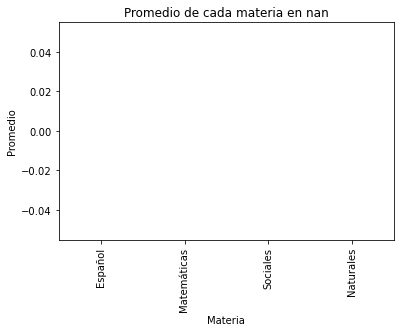

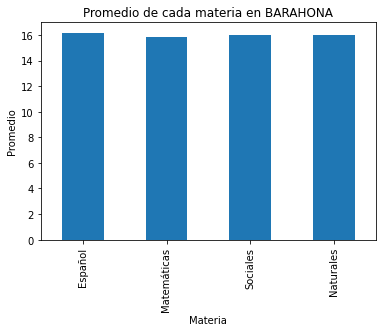

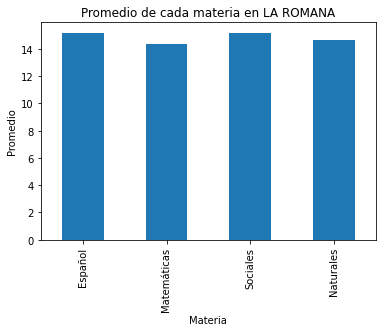

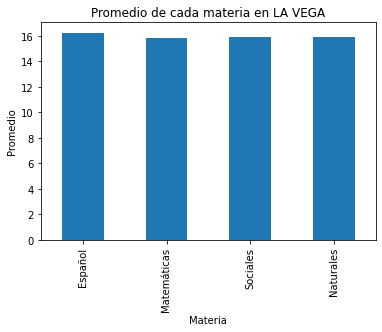

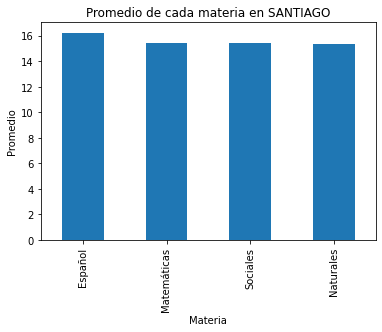

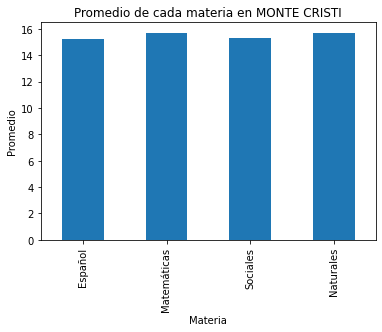

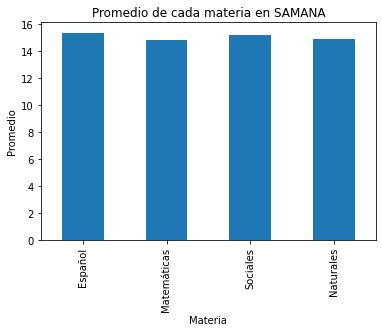

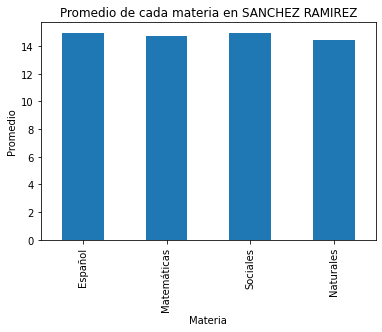

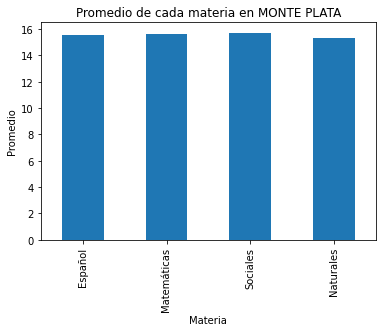

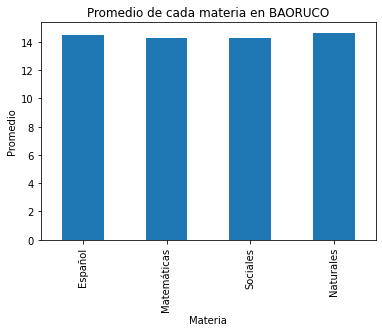

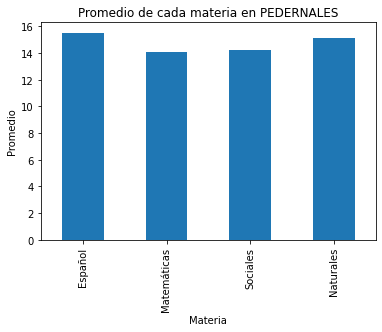

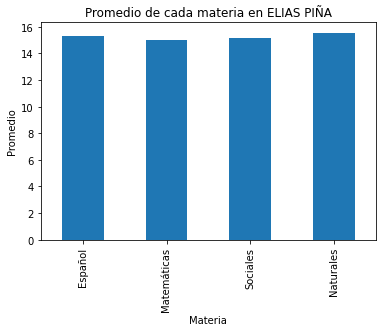

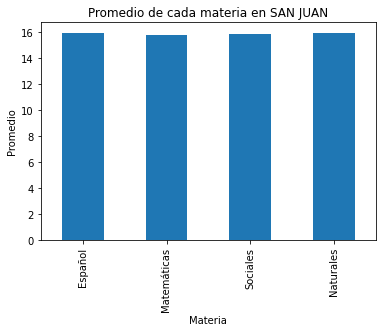

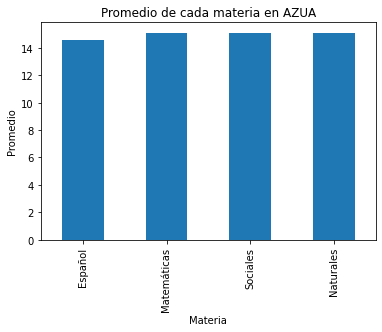

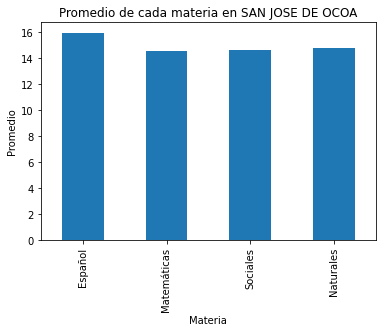

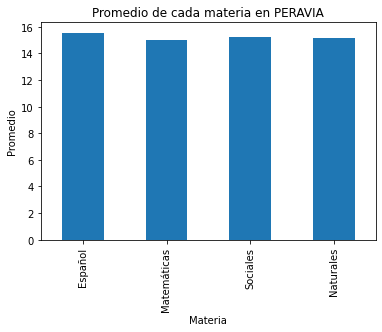

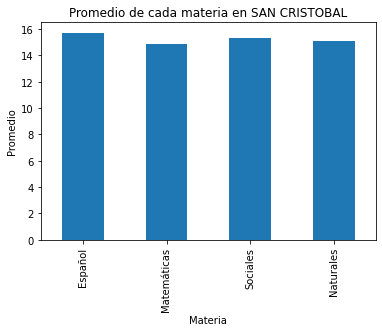

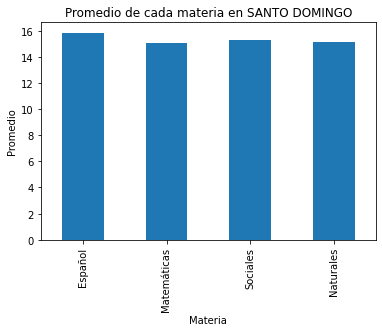

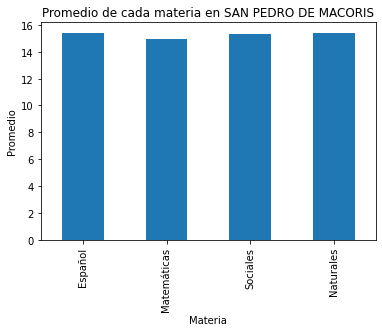

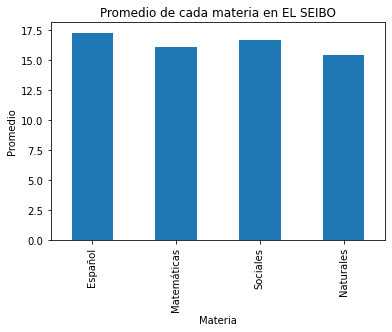

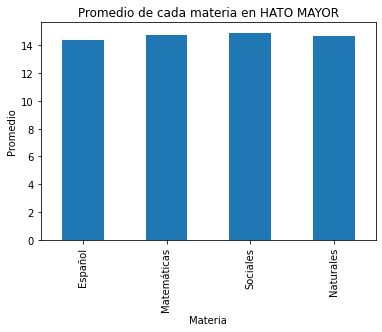

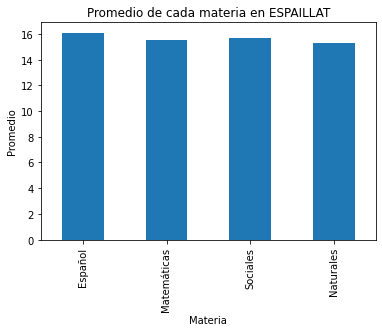

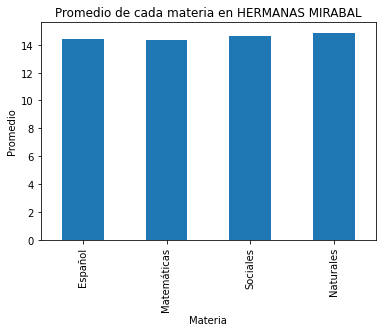

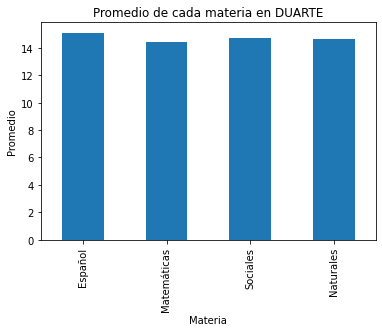

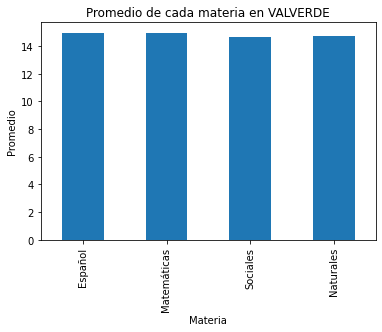

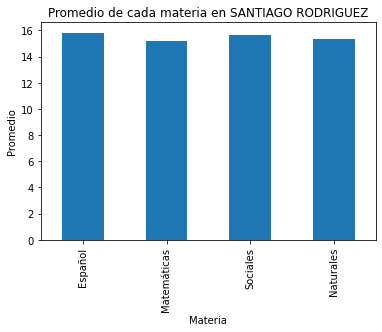

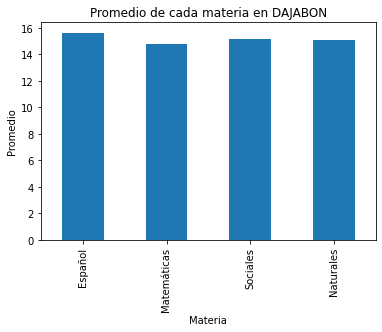

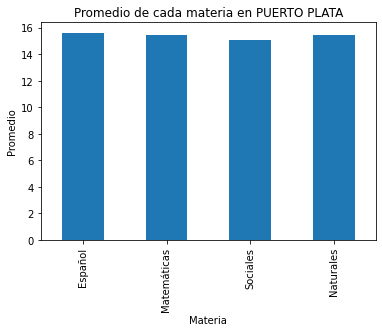

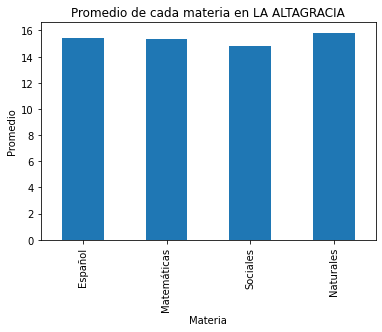

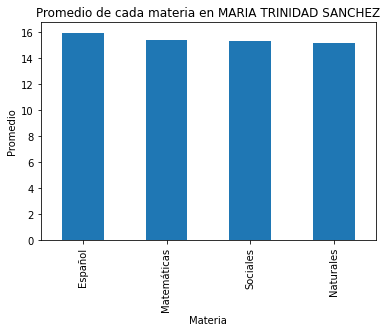

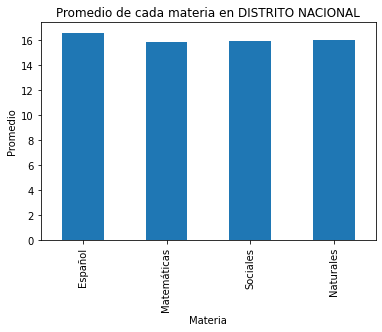

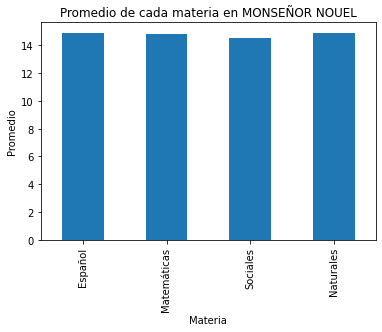

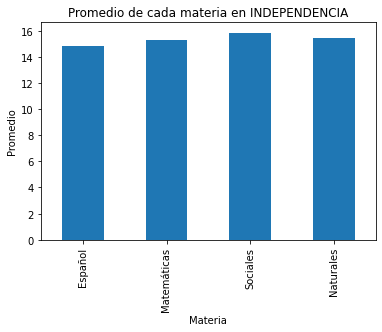

In [22]:
provincias = df["Provincia"].unique()

# crear un gráfico de barras para cada provincia
for provincia in provincias:
    # filtrar los datos correspondientes a la provincia actual
    datos_provincia = df[df["Provincia"] == provincia]
    
    # calcular el promedio de cada materia para la provincia actual
    promedios = datos_provincia[["Español", "Matemáticas", "Sociales", "Naturales"]].mean()
    
    # crear un gráfico de barras para la provincia actual
    fig, ax = plt.subplots()
    promedios.plot(kind="bar", ax=ax)
    
    # agregar etiquetas y título
    ax.set_xlabel("Materia")
    ax.set_ylabel("Promedio")
    ax.set_title(f"Promedio de cada materia en {provincia}")
    plt.show()